In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, mean_squared_error, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from collections import defaultdict
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.impute import SimpleImputer
import pickle


# Add parent directory to path to access custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.modelling_functions import create_multi_class_target, create_target_variable, analyse_best_model

In [2]:
# --- 1. Load Data ---
try:
    data = pd.read_csv(r'C:\Users\epoch_bpjmdqk\Documents\Code\data\processed\consumer_staples_data.csv', index_col='Date', parse_dates=True)
except FileNotFoundError:
    print("Error: The data file was not found. Please update the file path.")
    sys.exit()

# Define the target and split date
target_ticker = 'WMT'
# Split date set earlier to ensure test set is not empty with longer windows
split_date = '2023-01-01'

In [3]:
# --- 2. DEFINE THE EXPERIMENTS ---
# Define feature engineering configurations
feature_configs = {
    'baseline': None,
    # 'poly_2': {'name': 'PolynomialFeatures', 'params': {'degree': 2, 'include_bias': False}},
    'pca_3': {'name': 'PCA', 'params': {'n_components': 3}},
    'pruned_10': {'name': 'FeaturePruning', 'params': {'n_features_to_select': 10}}
}

# Define target configurations
target_configs = [
    {'type': 'binary', 'window': 5, 'threshold': 0.005},
    {'type': 'multi_class', 'window': 5, 'threshold': 0.01},
    {'type': 'multi_class_extreme', 'window': 5, 'threshold': 0.005, 'extreme_threshold': 0.02}, # Added new experiment
    {'type': 'regression', 'window': 5},
]

# Define model configurations for classification and regression with coarse param grids
models_cls = [
    {'name': 'XGBoost', 'class': XGBClassifier, 'initial_params': {'eval_metric': 'logloss', 'random_state': 42}, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [3, 5]}},
    {'name': 'CatBoost', 'class': CatBoostClassifier, 'initial_params': {'verbose': False, 'random_state': 42}, 'param_grid': {'n_estimators': [50, 100], 'depth': [3, 5]}},
    {'name': 'RandomForest', 'class': RandomForestClassifier, 'initial_params': {'random_state': 42, 'class_weight': 'balanced'}, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [5, 10]}},
]

models_reg = [
    {'name': 'XGBoost', 'class': XGBRegressor, 'initial_params': {'objective': 'reg:squarederror', 'random_state': 42}, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [3, 5]}},
    {'name': 'LinearRegression', 'class': LinearRegression, 'initial_params': {}, 'param_grid': {}}, # No params to tune for Linear Regression
]

In [4]:
import pandas as pd

# It's still good practice to set these options, although they won't affect the Index object's print behavior.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Test Binary Target
binary_data = data.copy()
binary_data = create_target_variable(binary_data, target_ticker, window=5, threshold=0.005)
print('BINARY_TARGET_COLUMNS:', binary_data.columns.tolist())

# 2. Test Multi-Class Target
multi_class_data = data.copy()
multi_class_data = create_multi_class_target(multi_class_data, target_ticker, window=5, threshold=0.01, extreme_threshold=0.02)
print('MULTI_CLASS_TARGET_COLUMNS:', multi_class_data.columns.tolist())

# 3. Test Regression Target
regression_data = data.copy()
regression_data[f'{target_ticker}_target_return'] = regression_data[f'Close_{target_ticker}'].pct_change(periods=5).shift(5)
print('REGRESSION_TARGET_COLUMNS:', regression_data.columns.tolist())

BINARY_TARGET_COLUMNS: ['Open_PG', 'High_PG', 'Low_PG', 'Close_PG', 'Volume_PG', 'Dividends_PG', 'Stock Splits_PG', 'Open_KO', 'High_KO', 'Low_KO', 'Close_KO', 'Volume_KO', 'Dividends_KO', 'Stock Splits_KO', 'Open_PEP', 'High_PEP', 'Low_PEP', 'Close_PEP', 'Volume_PEP', 'Dividends_PEP', 'Stock Splits_PEP', 'Open_WMT', 'High_WMT', 'Low_WMT', 'Close_WMT', 'Volume_WMT', 'Dividends_WMT', 'Stock Splits_WMT', 'Open_COST', 'High_COST', 'Low_COST', 'Close_COST', 'Volume_COST', 'Dividends_COST', 'Stock Splits_COST', 'Open_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Close_^GSPC', 'Volume_^GSPC', 'Dividends_^GSPC', 'Stock Splits_^GSPC', 'COST_HighLow_Range', 'COST_OpenClose_Range', 'COST_Close_to_Range_Ratio', 'COST_True_Range', 'COST_ATR14', 'COST_Volume_Daily_Change', 'COST_Volume_MA_20D', 'COST_Volume_MA_Ratio', 'COST_OBV', 'COST_RSI14', 'COST_MACD_Line', 'COST_MACD_Signal', 'COST_MACD_Hist', 'COST_SMA_10', 'COST_SMA_20', 'COST_SMA_50', 'COST_EMA_12', 'COST_EMA_26', 'COST_BB_Middle20', 'COST_BB_Upper20

In [5]:
# --- 3. THE EXPERIMENTAL LOOP ---
all_results = []

for target_conf in target_configs:
    # A. Create the target variable
    data_target = data.copy()
    
    if target_conf['type'] == 'binary':
        data_target = create_target_variable(data_target, target_ticker, window=target_conf['window'], threshold=target_conf['threshold'])
        target_col = f'{target_ticker}_Target'
        model_list = models_cls
    elif 'multi_class' in target_conf['type']:
        extreme_threshold = target_conf.get('extreme_threshold', None)
        data_target = create_multi_class_target(data_target, target_ticker, window=target_conf['window'], threshold=target_conf['threshold'], extreme_threshold=extreme_threshold)
        target_col = f'{target_ticker}_Target_Multi'
        model_list = models_cls
    else: # regression
        data_target[f'{target_ticker}_target_return'] = data_target[f'Close_{target_ticker}'].pct_change(periods=target_conf['window']).shift(-target_conf['window'])
        target_col = f'{target_ticker}_target_return'
        model_list = models_reg


    # Drop rows with NaN in the target
    data_target.dropna(subset=[target_col], inplace=True)

    # Explicitly define y_full and drop the target column from X_full
    y_full = data_target[target_col]

    # Identify and drop target-related columns from the feature set
    tickers_to_drop = data_target.columns.str.split('_').str[1:].to_series().explode().unique()

    columns_to_drop = [
        f'Open_{target_ticker}',
        f'High_{target_ticker}',
        f'Low_{target_ticker}',
        f'Close_{target_ticker}'
    ]

    if target_conf['type'] == 'regression':
        columns_to_drop.append(f'{target_ticker}_target_return')
    else:
        columns_to_drop.append(f'{target_ticker}_target_return_{target_conf["window"]}D')

    # Create X_full by dropping the explicitly identified columns AND the target column
    # This ensures no leakage, as the target column is now guaranteed to be dropped.
    X_full = data_target.drop(columns=columns_to_drop + [target_col], errors='ignore')

    # Split data chronologically
    X_train_full = X_full.loc[:split_date]
    y_train_full = y_full.loc[:split_date]
    X_test_full = X_full.loc[split_date:]
    y_test_full = y_full.loc[split_date:]

    if target_conf['type'] in ['binary', 'multi_class', 'multi_class_extreme']:
        le = LabelEncoder()
        y_train_full = le.fit_transform(y_train_full)
        y_test_full = le.transform(y_test_full)
    
    # B. Loop through feature engineering configurations
    for feat_name, feat_config in feature_configs.items():
        print(f"\n--- Starting Experiment: Target={target_conf['type']}, Features={feat_name} ---")

        X_train_transformed = X_train_full.copy()
        X_test_transformed = X_test_full.copy()
        
        # Replace inf with NaN first
        X_train_transformed.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test_transformed.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Apply imputation universally to handle all NaNs
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_transformed))
        X_test_imputed = pd.DataFrame(imputer.transform(X_test_transformed))

        # This is the change: The baseline now gets the imputed data directly
        X_train_final = X_train_imputed
        X_test_final = X_test_imputed

        if feat_name == 'poly_2':
            transformer = PolynomialFeatures(**feat_config['params'])
            X_train_final = pd.DataFrame(transformer.fit_transform(X_train_imputed))
            X_test_final = pd.DataFrame(transformer.transform(X_test_imputed))

        elif feat_name == 'pca_3':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_imputed)
            X_test_scaled = scaler.transform(X_test_imputed)
            
            transformer = PCA(**feat_config['params'])
            X_train_final = pd.DataFrame(transformer.fit_transform(X_train_scaled))
            X_test_final = pd.DataFrame(transformer.transform(X_test_scaled))
        
        elif feat_name == 'pruned_10':
            # Use SelectKBest to select the top features based on the target type
            if target_conf['type'] == 'regression':
                selector = SelectKBest(score_func=f_regression, k=feat_config['params']['n_features_to_select'])
            else:
                selector = SelectKBest(score_func=f_classif, k=feat_config['params']['n_features_to_select'])
            
            # Fit and transform the data to select the best features
            X_train_final = pd.DataFrame(selector.fit_transform(X_train_imputed, y_train_full))
            X_test_final = pd.DataFrame(selector.transform(X_test_imputed))
        
        # E. Loop through models
        for model_conf in model_list:
            print(f"-> Running model: {model_conf['name']}")
            
            # F. Apply walk-forward validation (on the training data) with GridSearchCV
            tscv_inner = TimeSeriesSplit(n_splits=3)
            
            # Handle class imbalance for classification models
            model_initial_params = model_conf['initial_params'].copy()
            sample_weight = None

            if target_conf['type'] in ['binary', 'multi_class', 'multi_class_extreme']:
                y_train_full_series = pd.Series(y_train_full)
                class_counts = y_train_full_series.value_counts().sort_index()
                total_samples = class_counts.sum()
                class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
                
                if model_conf['name'] == 'XGBoost':
                    sample_weight = np.array([class_weights[y] for y in y_train_full])
                    model_initial_params['eval_metric'] = 'mlogloss'
                elif model_conf['name'] == 'CatBoost':
                    model_initial_params['class_weights'] = [class_weights[cls] for cls in sorted(class_weights.keys())]
                elif model_conf['name'] == 'RandomForest':
                    pass
            
            # Create a new model instance for this experiment
            model = model_conf['class'](**model_initial_params)

            # Define the GridSearchCV object
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=model_conf['param_grid'],
                scoring='f1_macro' if target_conf['type'] in ['binary', 'multi_class', 'multi_class_extreme'] else 'neg_mean_squared_error',
                cv=tscv_inner,
                n_jobs=-1,
                verbose=3
            )
            
            # Fit GridSearchCV 
            grid_search.fit(X_train_final, y_train_full, sample_weight=sample_weight)
            best_model = grid_search.best_estimator_

            # Evaluate on the unseen test data
            y_pred = best_model.predict(X_test_final)
            
            if target_conf['type'] == 'regression':
                performance = np.sqrt(mean_squared_error(y_test_full, y_pred))
            else:
                performance = f1_score(y_test_full, y_pred, average='macro', zero_division=0)
            
            # G. Store results
            all_results.append({
                'Feature_Set': feat_name,
                'Target_Type': target_conf['type'],
                'Window': target_conf['window'],
                'Model': model_conf['name'],
                'Test_Performance': performance,
                'Best_Params': grid_search.best_params_
            })


--- Starting Experiment: Target=binary, Features=baseline ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: CatBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Starting Experiment: Target=binary, Features=pca_3 ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: CatBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Starting Experiment: Target=binary, Features=pruned_10 ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [36 37] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


-> Running model: CatBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Starting Experiment: Target=multi_class, Features=baseline ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: CatBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Starting Experiment: Target=multi_class, Features=pca_3 ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: CatBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Starting Experiment: Target=multi_class, Features=pruned_10 ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [36 37] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


-> Running model: CatBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Starting Experiment: Target=multi_class_extreme, Features=baseline ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: CatBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Starting Experiment: Target=multi_class_extreme, Features=pca_3 ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: CatBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Starting Experiment: Target=multi_class_extreme, Features=pruned_10 ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, 

c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [36 37] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


-> Running model: CatBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Starting Experiment: Target=regression, Features=baseline ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: LinearRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits

--- Starting Experiment: Target=regression, Features=pca_3 ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: LinearRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits

--- Starting Experiment: Target=regression, Features=pruned_10 ---
-> Running model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
-> Running model: LinearRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [6]:
# --- 4. Display Final Summary ---
results_df = pd.DataFrame(all_results)
results_df['Test_Performance'] = results_df['Test_Performance'].round(4)
print("\n--- Final Coarse Modeling Results Summary ---")
print(results_df.sort_values(by='Test_Performance', ascending=False).to_string())


--- Final Coarse Modeling Results Summary ---
   Feature_Set          Target_Type  Window             Model  Test_Performance                             Best_Params
3        pca_3               binary       5           XGBoost            0.4702   {'max_depth': 5, 'n_estimators': 100}
7    pruned_10               binary       5          CatBoost            0.4424       {'depth': 3, 'n_estimators': 100}
4        pca_3               binary       5          CatBoost            0.4304        {'depth': 5, 'n_estimators': 50}
6    pruned_10               binary       5           XGBoost            0.4113    {'max_depth': 5, 'n_estimators': 50}
8    pruned_10               binary       5      RandomForest            0.4080   {'max_depth': 5, 'n_estimators': 100}
5        pca_3               binary       5      RandomForest            0.4019   {'max_depth': 5, 'n_estimators': 100}
1     baseline               binary       5          CatBoost            0.3798        {'depth': 5, 'n_estimators


--- Generating Visualization of Results ---


C:\Users\epoch_bpjmdqk\AppData\Local\Temp\ipykernel_18392\3558207878.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test_Performance', y='Experiment', data=classification_results.sort_values(by='Test_Performance', ascending=False), palette='viridis')


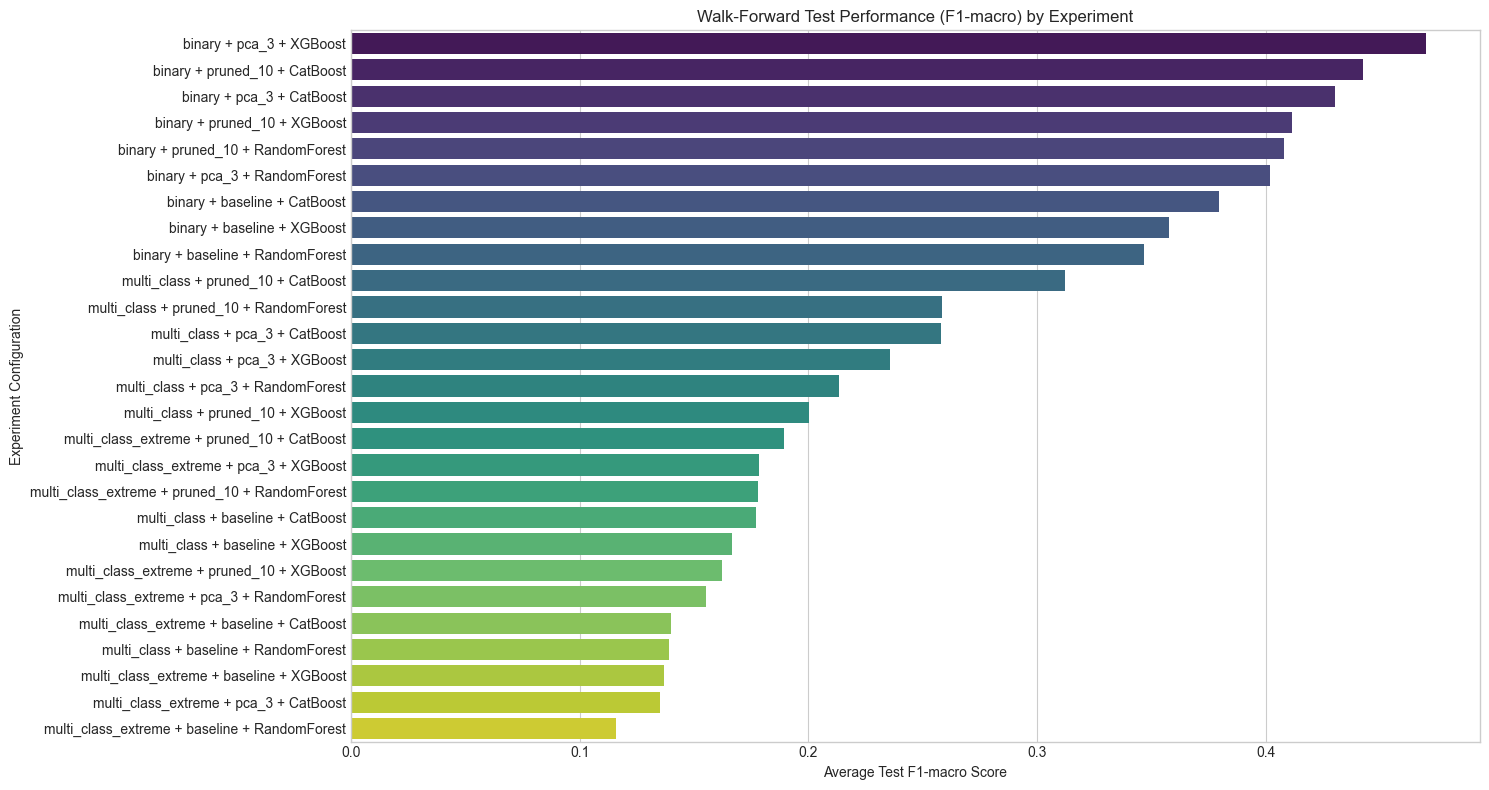

C:\Users\epoch_bpjmdqk\AppData\Local\Temp\ipykernel_18392\3558207878.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test_Performance', y='Experiment', data=regression_results.sort_values(by='Test_Performance', ascending=True), palette='plasma')


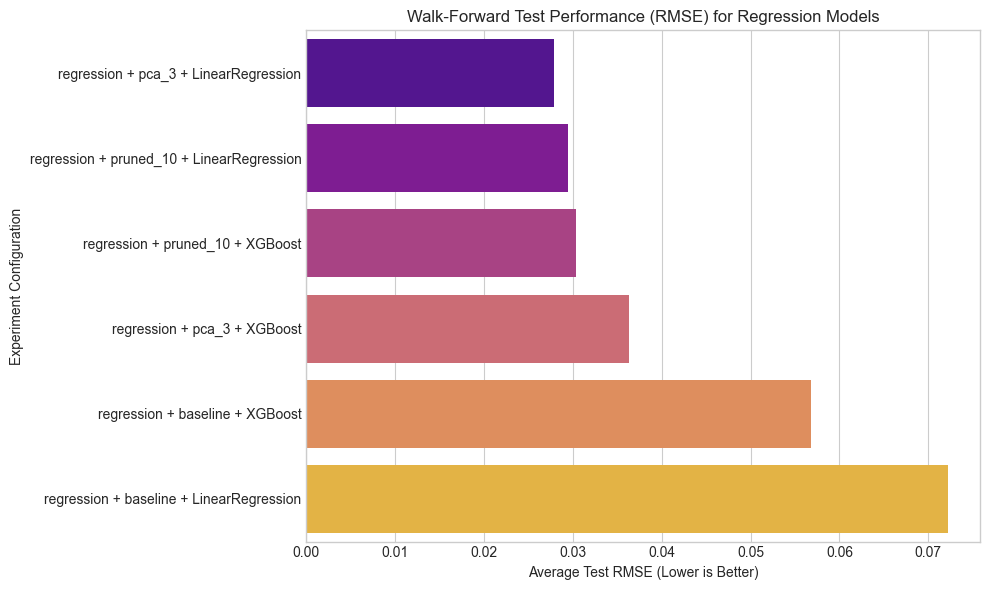


Visualization complete. The best combinations have the highest F1-macro score or lowest RMSE.


In [9]:
# --- 5. Add Evaluation and Visualization Step ---
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Generating Visualization of Results ---")

# Create a new column to combine the experiment details for plotting
results_df['Experiment'] = results_df['Target_Type'] + ' + ' + results_df['Feature_Set'] + ' + ' + results_df['Model']

# Filter out regression models for this plot as the metric (RMSE) is not comparable to F1-macro
classification_results = results_df[results_df['Target_Type'].isin(['binary', 'multi_class', 'multi_class_extreme'])].copy()

if not classification_results.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))
    sns.barplot(x='Test_Performance', y='Experiment', data=classification_results.sort_values(by='Test_Performance', ascending=False), palette='viridis')
    plt.title('Walk-Forward Test Performance (F1-macro) by Experiment')
    plt.xlabel('Average Test F1-macro Score')
    plt.ylabel('Experiment Configuration')
    plt.tight_layout()
    plt.show()

# Separate plot for regression results if available
regression_results = results_df[results_df['Target_Type'] == 'regression'].copy()

if not regression_results.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Test_Performance', y='Experiment', data=regression_results.sort_values(by='Test_Performance', ascending=True), palette='plasma')
    plt.title('Walk-Forward Test Performance (RMSE) for Regression Models')
    plt.xlabel('Average Test RMSE (Lower is Better)')
    plt.ylabel('Experiment Configuration')
    plt.tight_layout()
    plt.show()

print("\nVisualization complete. The best combinations have the highest F1-macro score or lowest RMSE.")